In [19]:
# cv_analysis.ipynb

import json
import os
import sys
from pathlib import Path
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

PROJECT_ROOT = Path("..").resolve()

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.data.dataloader import (
    ForgeryDataset,
    detection_collate_fn,
    get_val_transform,
)
from src.models.mask2former_v1 import Mask2FormerForgeryModel
from src.utils.config_utils import load_yaml, sanitize_model_kwargs
from src.training.train_cv import build_solution_df
from src.data.dataloader import ForgeryDataset
from src.models.kaggle_metric import score as kaggle_score

plt.style.use("ggplot")

In [36]:
# -----------------
# Constants / Paths
# -----------------

OOF_ROOT = PROJECT_ROOT / "experiments" / "oof_results"
FULL_TRAIN_ROOT = PROJECT_ROOT / "experiments" / "full_train_results"

CLS_THRESHOLD_PATH = (
    PROJECT_ROOT / "experiments" / "cls_threshold_sweep" / "cls_threshold_sweep.csv"
)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CFG_PATH = PROJECT_ROOT / "config" / "base.yaml"

CLPSE_ROOT = PROJECT_ROOT / "experiments" / "cls_collapse"

SAMPLEDUMP_ROOT = PROJECT_ROOT / "experiments" / "oof_results"

### OOF CV results

In [21]:
# List what's in experiments/oof_results/
oof_items = list(OOF_ROOT.iterdir())
oof_dirs = sorted([p.name for p in oof_items if p.is_dir()])
oof_files = sorted([p.name for p in oof_items if p.is_file()])

print("OOF dirs:", oof_dirs)
if oof_files:
    print("OOF loose files:", oof_files)


OOF dirs: ['mini_smoke']
OOF loose files: ['fold_1_oof.csv', 'fold_2_oof.csv', 'fold_3_oof.csv', 'oof_metrics.json', 'oof_predictions.csv', 'sanity_random_200.csv']


In [22]:
def load_run(names):
    """
    names:
      - str: dir name under OOF_ROOT OR filename under OOF_ROOT
      - list/tuple[str]: load multiple; returns dict keyed by run/filename
    """
    if isinstance(names, (list, tuple)):
        return {str(n): load_run(str(n)) for n in names}

    name = str(names)
    p = OOF_ROOT / name

    # Case A: run directory
    if p.is_dir():
        run_dir = p
        oof_csv = run_dir / "oof_predictions.csv"
        metrics_json = run_dir / "oof_metrics.json"

        oof_df = pd.read_csv(oof_csv) if oof_csv.exists() else None
        metrics = json.load(metrics_json.open()) if metrics_json.exists() else None

        fold_files = sorted(run_dir.glob("fold_*_oof.csv"))
        fold_dfs = {f.stem: pd.read_csv(f) for f in fold_files}

        return {"name": run_dir.name, "path": run_dir, "oof": oof_df, "metrics": metrics, "folds": fold_dfs}

    # Case B: loose file
    if p.is_file():
        if p.suffix.lower() == ".csv":
            return {"name": p.name, "path": p, "oof": pd.read_csv(p), "metrics": None, "folds": {}}
        if p.suffix.lower() == ".json":
            return {"name": p.name, "path": p, "oof": None, "metrics": json.load(p.open()), "folds": {}}
        raise ValueError(f"Unsupported file type: {p.suffix}")

    raise FileNotFoundError(f"Not found under OOF_ROOT: {name}")

# Use load_run(name | [names]) to load one or more CV runs or loose files from experiments/oof_results/
runs = load_run(["mini_smoke"])  # or: load_run("mini_smoke"), load_run("oof_predictions.csv")

print("Loaded:")
if isinstance(runs, dict) and "name" not in runs:
    for k, v in runs.items():
        print(f" - {v['name']} ({v['path']})")
else:
    print(f" - {runs['name']} ({runs['path']})")



Loaded:
 - mini_smoke (C:\Users\piiop\Desktop\Portfolio\Projects\RecodAI_LUC\experiments\oof_results\mini_smoke)


=== Loaded runs ===

mini_smoke
  Mean CV   : 0.45401720572170645
  OOF score : 0.4540016144226748
  Folds     : [0.37331664193408787, 0.45971014492753626, 0.5290248303034952]


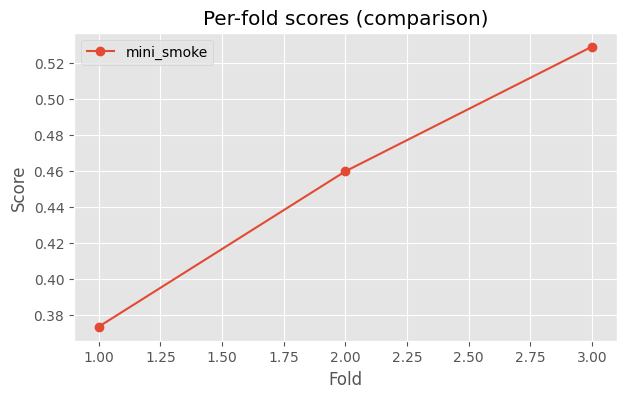

In [23]:
def show_run_metrics(names):
    """
    Pass a run dir name (str) or list of names to compare.
    """
    runs = load_run(names)
    if isinstance(runs, dict) and "name" not in runs:
        items = list(runs.values())
    else:
        items = [runs]

    # Clean summary header
    print("=== Loaded runs ===")
    for r in items:
        m = r["metrics"] or {}
        mean_cv = m.get("mean_cv", None)
        oof_score = m.get("oof_score", None)
        fold_scores = m.get("fold_scores", None)

        print(f"\n{r['name']}")
        print(f"  Mean CV   : {mean_cv}")
        print(f"  OOF score : {oof_score}")
        if fold_scores is not None:
            print(f"  Folds     : {fold_scores}")

    # Comparison plot (only for runs that have fold_scores)
    plot_items = [(r["name"], (r["metrics"] or {}).get("fold_scores")) for r in items]
    plot_items = [(n, fs) for (n, fs) in plot_items if fs is not None]

    if plot_items:
        plt.figure(figsize=(7, 4))
        for name, fs in plot_items:
            plt.plot(range(1, len(fs) + 1), fs, marker="o", label=name)
        plt.xlabel("Fold")
        plt.ylabel("Score")
        plt.title("Per-fold scores (comparison)")
        plt.legend()
        plt.show()

    return runs

# Single run
_ = show_run_metrics("mini_smoke")

# Compare multiple runs
# _ = show_run_metrics(["mini_smoke", "some_other_run"])



## CollapseLogger

In [24]:
# ---- Use an already-loaded run from `runs` ----
run = runs["mini_smoke"]  # must exist in `runs`

OOF_RUN_DIR = run["path"]
oof_metrics = run["metrics"] or {}
oof_predictions = run["oof"]
fold_dfs = run["folds"]

print("\n== oof_predictions.csv (head) ==")

print("\nFound fold CSVs:", list(fold_dfs.keys()))



== oof_predictions.csv (head) ==

Found fold CSVs: ['fold_1_oof', 'fold_2_oof', 'fold_3_oof', 'fold_4_oof', 'fold_5_oof']


In [ ]:
# Rebuild solution_df and re-score to match train_cv additional pipeline verification

full_dataset = ForgeryDataset(transform=None)
solution_df = build_solution_df(full_dataset)

# Overall OOF score (ALIGN BY row_id, then score)
solution_df["row_id"] = solution_df["row_id"].astype(str)
oof_predictions["row_id"] = oof_predictions["row_id"].astype(str)
sub_aligned = (
    solution_df[["row_id"]]
    .merge(oof_predictions[["row_id", "annotation"]], on="row_id", how="left")
)

recomputed_oof = kaggle_score(
    solution_df[["row_id", "annotation", "shape"]].copy(),
    sub_aligned[["row_id", "annotation"]].copy(),
    row_id_column_name="row_id",
)

print("\n== Recomputed overall OOF score ==")
print("recomputed_oof:", float(recomputed_oof))

# Per-fold (recompute using the saved fold CSVs if present)
def fold_num_from_stem(stem: str) -> int:
    m = re.search(r"(\d+)", stem)
    return int(m.group(1)) if m else -1

if fold_dfs:
    # Build stable (row_id, occ) keys on the FULL solution_df once
    sol = solution_df.copy()
    sol["row_id"] = sol["row_id"].astype(str)
    sol["occ"] = sol.groupby("row_id").cumcount()

    fold_scores = []
    for stem, fdf in sorted(fold_dfs.items(), key=lambda kv: fold_num_from_stem(kv[0])):
        fnum = fold_num_from_stem(stem)

        sub = fdf.copy()
        sub["row_id"] = sub["row_id"].astype(str)
        # IMPORTANT: occ must follow the fold CSV order (this is what we’ll score)
        sub["occ"] = sub.groupby("row_id").cumcount()

        # Rebuild fold solution IN THE SAME ORDER AS sub (no sorting, no isin)
        fold_sol = sub[["row_id", "occ"]].merge(
            sol[["row_id", "occ", "annotation", "shape"]],
            on=["row_id", "occ"],
            how="left",
        )

        # Hard sanity checks (if these fail, your saved fold CSV isn't compatible with solution_df)
        assert len(fold_sol) == len(sub)
        if fold_sol["annotation"].isna().any() or fold_sol["shape"].isna().any():
            bad = fold_sol[fold_sol["annotation"].isna() | fold_sol["shape"].isna()].head(10)
            raise RuntimeError(f"{stem}: fold_sol has missing GT rows. Sample:\n{bad}")

        # Submission already in correct order; kaggle_score aligns by row order
        fold_sub = sub[["row_id", "annotation"]].copy()

        s = kaggle_score(
            fold_sol[["row_id", "annotation", "shape"]].copy(),
            fold_sub.copy(),
            row_id_column_name="row_id",
        )
        fold_scores.append((fnum, float(s)))

    fold_scores_df = pd.DataFrame(fold_scores, columns=["fold", "kaggle_metric"]).sort_values("fold")
    print("\n== Recomputed per-fold scores ==")
    display(fold_scores_df)


== Recomputed overall OOF score ==
recomputed_oof: 0.35100042296711775

== Recomputed per-fold scores ==


,fold,kaggle_metric
0,1,0.373317
1,2,0.459710
2,3,0.529025
3,4,0.850732
4,5,0.836098


In [ ]:
# Load ClsCollapseLogger outputs for the CV folds (from experiments/cls_collapse)

def _read_json(p: Path):
    with open(p, "r") as f:
        return json.load(f)

def _read_jsonl(p: Path):
    rows = []
    with open(p, "r") as f:
        for line in f:
            line = line.strip()
            if line:
                rows.append(json.loads(line))
    return pd.DataFrame(rows) if rows else pd.DataFrame()

def _read_table(p: Path):
    suf = p.suffix.lower()
    if suf == ".csv":
        return pd.read_csv(p)
    if suf in (".jsonl", ".ndjson"):
        return _read_jsonl(p)
    return None

def _fold_numbers_from_loaded_run(fold_dfs, oof_metrics):
    nums = []
    for k in (fold_dfs or {}).keys():
        m = re.search(r"(\d+)", str(k))
        if m:
            nums.append(int(m.group(1)))
    if nums:
        return sorted(set(nums))
    fs = (oof_metrics or {}).get("fold_scores", None)
    return list(range(1, len(fs) + 1)) if fs else []

fold_nums = _fold_numbers_from_loaded_run(fold_dfs, oof_metrics)

collapse_json = {}    # (fold, relpath) -> dict
collapse_tables = {}  # (fold, relpath) -> df

for fnum in fold_nums:
    run_name = f"cv_fold{fnum}"
    fold_dir = CLPSE_ROOT / run_name

    if fold_dir.is_dir():
        files = [p for p in fold_dir.rglob("*") if p.is_file()]
    else:
        files = [p for p in CLPSE_ROOT.rglob(f"*{run_name}*") if p.is_file()]

    for p in files:
        rel = str(p.relative_to(CLPSE_ROOT))
        suf = p.suffix.lower()

        if suf == ".json":
            try:
                collapse_json[(fnum, rel)] = _read_json(p)
            except Exception:
                pass
        elif suf in (".csv", ".jsonl", ".ndjson"):
            try:
                df = _read_table(p)
                if df is not None and len(df) > 0:
                    collapse_tables[(fnum, rel)] = df
            except Exception:
                pass

# ---- concise inventory (no blob dumps, no head() spam) ----
print(f"Loaded ClsCollapseLogger artifacts for folds: {fold_nums}")
print(f"  JSON blobs : {len(collapse_json)}")
print(f"  Tables     : {len(collapse_tables)}")

if collapse_tables:
    by_fold = {}
    for (fnum, rel), df in collapse_tables.items():
        by_fold.setdefault(fnum, []).append((rel, df))

    for fnum in sorted(by_fold):
        print(f"\nfold{fnum} tables:")
        for rel, df in sorted(by_fold[fnum], key=lambda x: x[0]):
            print(f"  - {rel} | shape={df.shape} | cols={list(df.columns)}")



Loaded ClsCollapseLogger artifacts for folds: [1, 2, 3, 4, 5]
  JSON blobs : 6
  Tables     : 9

fold1 tables:
  - cv_fold1\debug.jsonl | shape=(1102438, 53) | cols=['tag', 'fold', 'epoch', 'global_step', 'img_label', 'masks_shape', 'masks_sum', 'b', 'Q', 'Hm', 'Wm', 'tgt_shape', 'tgt_numel', 'tgt_sum', 'cost_shape', 'matched', 'num_gt', 'B', 'pos', 'total', 'pos_frac', 'thr', 'temp', 'authentic_frac', 'per_image_penalty_mean', 'loss_auth_penalty', 'reason', 'per_image', 'mask_probs', 'class_probs', 'img_probs', 'val_samples', 'masks_empty', 'gate_fail', 'num_keep0', 'cls_filtered_all_fg', 'rates', 'max_cls_prob', 'max_mask_prob', 'presence_mean', 'presence_min', 'presence_max', 'tau', 'loss_presence_auth', 'loss_forged_presence', 'fg_prob_per_query', 'fg_prob_mean', 'fg_prob_p95', 'fg_prob_max', 'no_fg_pre_keep', 'pred_auth_frac', 'pred_non_auth_count', 'pred_non_auth_area_ratio_mean']
  - cv_fold1\epoch_summary.csv | shape=(143, 11) | cols=['fold', 'epoch', 'epoch_loss', 'cls_max_mea

In [ ]:
# Convenience: key summaries across ALL loaded debug tables

def concat_tables(name_contains: str):
    dfs = []
    for (fold, rel), df in collapse_tables.items():
        if name_contains.lower() in rel.lower():
            d = df.copy()
            d["fold"] = fold
            d["_source"] = rel
            dfs.append(d)
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

step_losses = concat_tables("step")
epoch_summary = concat_tables("epoch")
debug_events = concat_tables("debug")

if len(step_losses):
    display(step_losses.describe(include="all"))

if len(epoch_summary):
    display(epoch_summary)

if len(debug_events):
    display(debug_events.head(25))


,fold,epoch,global_step,lr,loss_mask_bce,loss_mask_dice,loss_mask_cls,loss_img_auth,loss_auth_penalty,loss_total,w_mask_cls,w_auth_penalty,_source
count,356688.000000,356688.000000,356688.000000,3.566880e+05,356688.000000,356688.000000,356688.000000,356688.000000,3.566880e+05,356688.000000,356688.0,356688.0,356688
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cv_fold1\step_losses.csv
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123678
mean,1.979890,11.562231,9545.981244,1.000000e-04,0.109756,0.597631,0.286423,0.438047,1.081987e-03,1.528142,1.0,1.0,NaN
std,0.820346,7.162869,6186.656118,5.421018e-20,0.220063,0.231169,0.127735,0.264061,9.927872e-03,0.573820,0.0,0.0,NaN
min,1.000000,1.000000,0.000000,1.000000e-04,-0.000000,-0.000000,0.001061,0.000032,0.000000e+00,0.006600,1.0,1.0,NaN
25%,1.000000,5.000000,4053.000000,1.000000e-04,0.035604,0.462345,0.195710,0.241929,3.877074e-16,1.155737,1.0,1.0,NaN
50%,2.000000,11.000000,8822.000000,1.000000e-04,0.075364,0.612643,0.265405,0.407695,4.356185e-13,1.506349,1.0,1.0,NaN
75%,3.000000,18.000000,14767.000000,1.000000e-04,0.139101,0.763260,0.357932,0.605784,3.827923e-11,1.872492,1.0,1.0,NaN


,fold,epoch,epoch_loss,cls_max_mean,cls_max_p95,keep_rate@0.1,keep_rate@0.2,keep_rate@0.3,img_forged_mean,mask_max_mean,w_mask_cls,_source
0,1,1,2.021691,0.136009,0.136025,0.733333,0.000000,0.0,0.524097,0.877686,1.0,cv_fold1\epoch_summary.csv
1,1,2,1.807341,0.130609,0.130677,0.466667,0.000000,0.0,0.532895,1.000000,1.0,cv_fold1\epoch_summary.csv
2,1,3,1.682340,0.207237,0.207346,0.666667,0.133333,0.0,0.406712,0.999880,1.0,cv_fold1\epoch_summary.csv
3,1,4,1.619308,0.141077,0.141474,0.400000,0.000000,0.0,0.384231,1.000000,1.0,cv_fold1\epoch_summary.csv
4,1,5,1.537958,0.122101,0.123965,0.316667,0.000000,0.0,0.350370,1.000000,1.0,cv_fold1\epoch_summary.csv
...,...,...,...,...,...,...,...,...,...,...,...,...
408,3,1,2.528011,0.106473,0.106681,1.000000,0.000000,0.0,0.488744,0.978458,1.0,cv_fold3\epoch_summary.csv
409,3,2,2.200424,0.098079,0.098109,0.000000,0.000000,0.0,0.674299,0.934380,1.0,cv_fold3\epoch_summary.csv
410,3,3,2.079211,0.132215,0.132756,1.000000,0.000000,0.0,0.626075,0.998246,1.0,cv_fold3\epoch_summary.csv
411,3,4,2.096675,0.087008,0.151286,0.250000,0.000000,0.0,0.290447,0.932729,1.0,cv_fold3\epoch_summary.csv


,tag,fold,epoch,global_step,img_label,masks_shape,masks_sum,b,Q,Hm,...,loss_forged_presence,fg_prob_per_query,fg_prob_mean,fg_prob_p95,fg_prob_max,no_fg_pre_keep,pred_auth_frac,pred_non_auth_count,pred_non_auth_area_ratio_mean,_source
0,batch_target0,1,10.0,7810.0,1.0,"[2, 256, 256]",3757.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cv_fold1\debug.jsonl
1,hungarian_match_input,1,10.0,7810.0,NaN,NaN,NaN,0.0,15.0,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cv_fold1\debug.jsonl
2,hungarian_match_result,1,10.0,7810.0,NaN,NaN,NaN,0.0,15.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cv_fold1\debug.jsonl
3,hungarian_match_input,1,10.0,7810.0,NaN,NaN,NaN,1.0,15.0,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cv_fold1\debug.jsonl
4,hungarian_match_result,1,10.0,7810.0,NaN,NaN,NaN,1.0,15.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cv_fold1\debug.jsonl
5,hungarian_match_input,1,10.0,7810.0,NaN,NaN,NaN,2.0,15.0,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cv_fold1\debug.jsonl
6,hungarian_match_result,1,10.0,7810.0,NaN,NaN,NaN,2.0,15.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cv_fold1\debug.jsonl
7,hungarian_match_input,1,10.0,7810.0,NaN,NaN,NaN,3.0,15.0,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cv_fold1\debug.jsonl
8,hungarian_match_result,1,10.0,7810.0,NaN,NaN,NaN,3.0,15.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cv_fold1\debug.jsonl
9,loss_cls_targets,1,10.0,7810.0,NaN,NaN,NaN,NaN,15.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cv_fold1\debug.jsonl


In [ ]:
# Debug-event aggregation (OOF inference) across folds

# Collect debug.jsonl-like tables from all folds
dbg_parts = []
for (fold, rel), df in collapse_tables.items():
    rel_l = rel.lower()
    is_debug = ("debug" in rel_l) and (rel_l.endswith(".jsonl") or rel_l.endswith(".ndjson"))
    if is_debug:
        d = df.copy()
        d["fold"] = fold
        d["_source"] = rel
        dbg_parts.append(d)

dbg = pd.concat(dbg_parts, ignore_index=True) if dbg_parts else pd.DataFrame()
print("dbg shape:", dbg.shape)
print("cols:", list(dbg.columns))

# Coerce numeric cols that may have been logged as strings/objects
for c in ["max_cls_prob", "max_mask_prob", "thr", "temp"]:
    if c in dbg.columns:
        dbg[c] = pd.to_numeric(dbg[c], errors="coerce")

# Ensure expected flags exist + boolean-ish
flag_cols = ["masks_empty", "gate_fail", "num_keep0", "cls_filtered_all_fg", "any_fg_pre_keep", "any_fg_post_keep"]
for c in flag_cols:
    if c in dbg.columns:
        if dbg[c].dtype == object:
            dbg[c] = dbg[c].astype(str).str.lower().isin(["true", "1", "yes"])
        else:
            dbg[c] = dbg[c].astype(bool)

# 2) Optional: restrict to inference-only rows if your logger mixes tags
if "tag" in dbg.columns and len(dbg):
    infer = dbg[dbg["tag"].astype(str).str.contains("infer", case=False, na=False)].copy()
    if len(infer) > 0:
        dbg = infer
        print("Filtered to infer-tag rows:", dbg.shape)

# 3) Global counts (only compute keys that exist)
total = len(dbg)
global_stats = {"total_rows": int(total)}
if total:
    if "masks_empty" in dbg.columns:
        global_stats["masks_numel_eq_0"] = int(dbg["masks_empty"].sum())
    if "gate_fail" in dbg.columns:
        global_stats["gate_pass_false"] = int(dbg["gate_fail"].sum())
    if "num_keep0" in dbg.columns:
        global_stats["num_keep_eq_0"] = int(dbg["num_keep0"].sum())
    # preferred explicit flags if present
    if "cls_filtered_all_fg" in dbg.columns:
        global_stats["fg_pre_true_post_false"] = int(dbg["cls_filtered_all_fg"].sum())
    # fallback if you logged pre/post flags instead
    elif ("any_fg_pre_keep" in dbg.columns) and ("any_fg_post_keep" in dbg.columns):
        global_stats["fg_pre_true_post_false"] = int((dbg["any_fg_pre_keep"] & (~dbg["any_fg_post_keep"])).sum())
    if "any_fg_pre_keep" in dbg.columns:
        global_stats["any_fg_pre_keep_false"] = int((~dbg["any_fg_pre_keep"]).sum())

stats_df = pd.Series(global_stats, name="count").to_frame()
if total:
    stats_df["fraction"] = stats_df["count"] / total
display(stats_df)

# 4) Per-fold counts + prob summaries
def p95(x):
    x = pd.to_numeric(x, errors="coerce").dropna()
    return float(x.quantile(0.95)) if len(x) else np.nan

if len(dbg) and "fold" in dbg.columns:
    agg = {"rows": ("fold", "size")}

    if "masks_empty" in dbg.columns: agg["masks_numel_eq_0"] = ("masks_empty", "sum")
    if "gate_fail" in dbg.columns: agg["gate_pass_false"] = ("gate_fail", "sum")
    if "num_keep0" in dbg.columns: agg["num_keep_eq_0"] = ("num_keep0", "sum")

    if "cls_filtered_all_fg" in dbg.columns:
        agg["fg_pre_true_post_false"] = ("cls_filtered_all_fg", "sum")
    elif ("any_fg_pre_keep" in dbg.columns) and ("any_fg_post_keep" in dbg.columns):
        dbg["_fg_pre_true_post_false"] = dbg["any_fg_pre_keep"] & (~dbg["any_fg_post_keep"])
        agg["fg_pre_true_post_false"] = ("_fg_pre_true_post_false", "sum")
    if "any_fg_pre_keep" in dbg.columns:
        dbg["_any_fg_pre_keep_false"] = ~dbg["any_fg_pre_keep"]
        agg["any_fg_pre_keep_false"] = ("_any_fg_pre_keep_false", "sum")

    if "max_cls_prob" in dbg.columns:
        agg["max_cls_prob_mean"] = ("max_cls_prob", "mean")
        agg["max_cls_prob_p95"] = ("max_cls_prob", p95)
    if "max_mask_prob" in dbg.columns:
        agg["max_mask_prob_mean"] = ("max_mask_prob", "mean")
        agg["max_mask_prob_p95"] = ("max_mask_prob", p95)

    per_fold = (
        dbg.groupby("fold", dropna=False)
           .agg(**agg)
           .reset_index()
           .sort_values("fold")
    )
    display(per_fold)

# 5) Inspect the “cls_threshold filtered everything” rows (only if columns exist)
need = ["fold", "epoch", "global_step", "img_label", "masks_empty", "gate_fail", "num_keep0",
        "max_cls_prob", "max_mask_prob", "thr", "temp", "reason"]
have = [c for c in need if c in dbg.columns]

if len(dbg):
    if "cls_filtered_all_fg" in dbg.columns:
        suspect = dbg[dbg["cls_filtered_all_fg"] == True][have].copy()
        print("suspect rows:", len(suspect))
        display(suspect.head(50))
    elif ("any_fg_pre_keep" in dbg.columns) and ("any_fg_post_keep" in dbg.columns):
        suspect = dbg[(dbg["any_fg_pre_keep"] == True) & (dbg["any_fg_post_keep"] == False)][have].copy()
        print("suspect rows:", len(suspect))
        display(suspect.head(50))


dbg shape: (3768610, 54)
cols: ['tag', 'fold', 'epoch', 'global_step', 'img_label', 'masks_shape', 'masks_sum', 'b', 'Q', 'Hm', 'Wm', 'tgt_shape', 'tgt_numel', 'tgt_sum', 'cost_shape', 'matched', 'num_gt', 'B', 'pos', 'total', 'pos_frac', 'thr', 'temp', 'authentic_frac', 'per_image_penalty_mean', 'loss_auth_penalty', 'reason', 'per_image', 'mask_probs', 'class_probs', 'img_probs', 'val_samples', 'masks_empty', 'gate_fail', 'num_keep0', 'cls_filtered_all_fg', 'rates', 'max_cls_prob', 'max_mask_prob', 'presence_mean', 'presence_min', 'presence_max', 'tau', 'loss_presence_auth', 'loss_forged_presence', 'fg_prob_per_query', 'fg_prob_mean', 'fg_prob_p95', 'fg_prob_max', 'no_fg_pre_keep', 'pred_auth_frac', 'pred_non_auth_count', 'pred_non_auth_area_ratio_mean', '_source']
Filtered to infer-tag rows: (15, 54)


,count,fraction
total_rows,15,1.000000
masks_numel_eq_0,15,1.000000
gate_pass_false,15,1.000000
num_keep_eq_0,14,0.933333
fg_pre_true_post_false,15,1.000000


,fold,rows,masks_numel_eq_0,gate_pass_false,num_keep_eq_0,fg_pre_true_post_false,max_cls_prob_mean,max_cls_prob_p95,max_mask_prob_mean,max_mask_prob_p95
0,1,5,5,5,5,5,NaN,NaN,NaN,NaN
1,2,5,5,5,5,5,NaN,NaN,NaN,NaN
2,3,5,5,5,4,5,NaN,NaN,NaN,NaN


suspect rows: 15


,fold,epoch,global_step,img_label,masks_empty,gate_fail,num_keep0,max_cls_prob,max_mask_prob,thr,temp,reason
388578,1,NaN,NaN,NaN,True,True,True,NaN,NaN,NaN,NaN,NaN
625806,1,NaN,NaN,NaN,True,True,True,NaN,NaN,NaN,NaN,NaN
729329,1,NaN,NaN,NaN,True,True,True,NaN,NaN,NaN,NaN,NaN
953632,1,NaN,NaN,NaN,True,True,True,NaN,NaN,NaN,NaN,NaN
1009711,1,NaN,NaN,NaN,True,True,True,NaN,NaN,NaN,NaN,NaN
1814269,2,NaN,NaN,NaN,True,True,True,NaN,NaN,NaN,NaN,NaN
2051547,2,NaN,NaN,NaN,True,True,True,NaN,NaN,NaN,NaN,NaN
2155090,2,NaN,NaN,NaN,True,True,True,NaN,NaN,NaN,NaN,NaN
2379433,2,NaN,NaN,NaN,True,True,True,NaN,NaN,NaN,NaN,NaN
2435522,2,NaN,NaN,NaN,True,True,True,NaN,NaN,NaN,NaN,NaN


In [40]:
# -------------------------
# Fold-level val_loader debug counts (from oof_inference_debug events)
# -------------------------

def _extract_debug_event(df: pd.DataFrame, tag: str) -> pd.DataFrame:
    if df is None or len(df) == 0:
        return pd.DataFrame()

    # Most common format: columns include ["tag", "payload", ...]
    if "tag" in df.columns:
        ev = df[df["tag"].astype(str) == tag].copy()
    else:
        # fallback if tag was flattened into a column name
        ev = df.copy()

    if len(ev) == 0:
        return pd.DataFrame()

    if "payload" in ev.columns:
        # payload is a dict -> flatten
        payloads = ev["payload"].tolist()
        flat = pd.json_normalize(payloads, sep=".")
        # preserve fold if present as a top-level col too
        return flat
    else:
        # already flattened
        return ev

# dbg should already exist from your earlier "debug*.jsonl" concat
oof_inf = _extract_debug_event(dbg, "oof_inference_debug")
oof_area = _extract_debug_event(dbg, "oof_pred_area_stats")

if len(oof_inf) == 0:
    print("No oof_inference_debug events found in dbg (check debug jsonl ingestion).")
else:
    # keep only the key fields we care about (and anything else that exists)
    cols = [
        "fold", "val_samples",
        "masks_empty", "gate_fail", "num_keep0", "cls_filtered_all_fg", "no_fg_pre_keep",
        "rates.masks_empty", "rates.gate_fail", "rates.num_keep0", "rates.cls_filtered_all_fg", "rates.no_fg_pre_keep",
        "max_cls_prob.mean", "max_cls_prob.p95", "max_cls_prob.max",
        "max_mask_prob.mean", "max_mask_prob.p95", "max_mask_prob.max",
    ]
    keep = [c for c in cols if c in oof_inf.columns]
    oof_inf_view = oof_inf[keep].copy()

    # numeric coercion (safe)
    for c in oof_inf_view.columns:
        if c != "fold":
            oof_inf_view[c] = pd.to_numeric(oof_inf_view[c], errors="ignore")

    oof_inf_view = oof_inf_view.sort_values("fold") if "fold" in oof_inf_view.columns else oof_inf_view
    display(oof_inf_view)

if len(oof_area):
    cols = ["fold", "val_samples", "pred_auth_frac", "pred_non_auth_count", "pred_non_auth_area_ratio_mean"]
    keep = [c for c in cols if c in oof_area.columns]
    oof_area_view = oof_area[keep].copy()
    for c in oof_area_view.columns:
        if c != "fold":
            oof_area_view[c] = pd.to_numeric(oof_area_view[c], errors="ignore")
    oof_area_view = oof_area_view.sort_values("fold") if "fold" in oof_area_view.columns else oof_area_view
    display(oof_area_view)


C:\Users\piiop\AppData\Local\Temp\ipykernel_9504\3598422253.py:50: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  oof_inf_view[c] = pd.to_numeric(oof_inf_view[c], errors="ignore")


,fold,val_samples,masks_empty,gate_fail,num_keep0,cls_filtered_all_fg,no_fg_pre_keep
388578,1,1726.0,True,True,True,True,NaN
625806,1,1726.0,True,True,True,True,NaN
729329,1,1726.0,True,True,True,True,NaN
953632,1,1726.0,True,True,True,True,249.0
1009711,1,1726.0,True,True,True,True,0.0
1814269,2,1725.0,True,True,True,True,NaN
2051547,2,1725.0,True,True,True,True,NaN
2155090,2,1725.0,True,True,True,True,NaN
2379433,2,1725.0,True,True,True,True,0.0
2435522,2,1725.0,True,True,True,True,2.0


In [ ]:
# sanity_random_200 check

In [37]:
csvs = sorted(SAMPLEDUMP_ROOT.rglob("sanity_random_200.csv"))
assert csvs, "No sanity_random_200.csv found under sanity_dumps"

df = pd.read_csv(csvs[-1])

summary = {
    "rows": len(df),
    "forged_folder_rate": df["is_forged_folder"].mean(),
    "image_label_rate": df["image_label"].mean(),
    "any_instances_rate": (df["num_instances"] > 0).mean(),
    "mean_union_sum": df["union_sum"].mean(),
    "mean_max_instance_sum": df["max_instance_sum"].mean(),
}

display(pd.Series(summary, name="value").to_frame())


,value
rows,200.000
forged_folder_rate,0.545
image_label_rate,0.545
any_instances_rate,0.545
mean_union_sum,30973.545
mean_max_instance_sum,26154.455


In [38]:
# Cross-tab: are forged-folder images ever labeled authentic?
pd.crosstab(df["is_forged_folder"], df["image_label"])

image_label,0.0,1.0
is_forged_folder,,
False,91,0
True,0,109


In [39]:
# How often do we have forged-folder but zero instances?
df.query("is_forged_folder == True and num_instances == 0").shape[0]

0